# Looking at the "Object Catalogs": merged tract-patch catalogs in DC2 Run 1.1p
<br>Owner: **Michael Wood-Vasey** ([@wmwv](https://github.com/LSSTDESC/DC2-analysis/issues/new?body=@wmwv))
<br>Last Verified to Run: **2018-07-24**

### Purpose:
Demonstrate reading a static-sky object catalog from photometry on the coadd images based on the static coadd catalog.  Shows the example of plotting a color-color stellar locus against the data to demonstrate some basic use of the magnitudes and extendedness columns.

### Learning Objectives:
After working through and studying this Notebook you should be able to
1. Read in the DC2 Run 1.1p object catalog directly from the flat files.
2. Construct a color-color diagram for stars
3. Overplot a stellar locus model

### Logistics
This is intended to be runnable at NERSC through the https://jupyter-dev.nersc.gov interface from a local git clone of https://github.com/LSSTDESC/DC2-analysis in your NERSC directory.  But you can also run it wherever, with appropriate adjustment of the 'repo' location to point to a place where you have a Butler repo will all of the images. Instructions for setting up the proper python kernel can be found here: https://confluence.slac.stanford.edu/x/1_ubDQ


In [1]:
import os

import numpy as np

%matplotlib inline 
import matplotlib.pyplot as plt

import pandas as pd

In [2]:
# cmap = 'Oranges'
cmap = 'viridis_r'

In [3]:
merged_tract_data_dir = '/global/projecta/projectdirs/lsst/global/in2p3/Run1.1/object_catalog/'

In the LSST Data Management processing, the sky is divided into tracts.  Each tract is divided into patches (8x8 in this processing).  The object catalog files are saved by tract.  These files are HDF5 files which are divided into group keys by patch.

For more information see: [How to the Run 1.1p skymap](Plotting_the_Run1.1p_skymap.ipynb)

In [4]:
tract, patch = 4849, 16
basename = 'merged_tract_%d.hdf5' % tract
key = 'coadd_%d_%2d' % (tract, patch)

In [5]:
merged_tract_file = os.path.join(merged_tract_data_dir, basename)

In [6]:
df = pd.read_hdf(merged_tract_file, key=key)

In [7]:
print(len(df), "objects")

15958 objects


Text(0.5, 1.0, 'Color-color diagram of all objects in one tract of object catalogs')

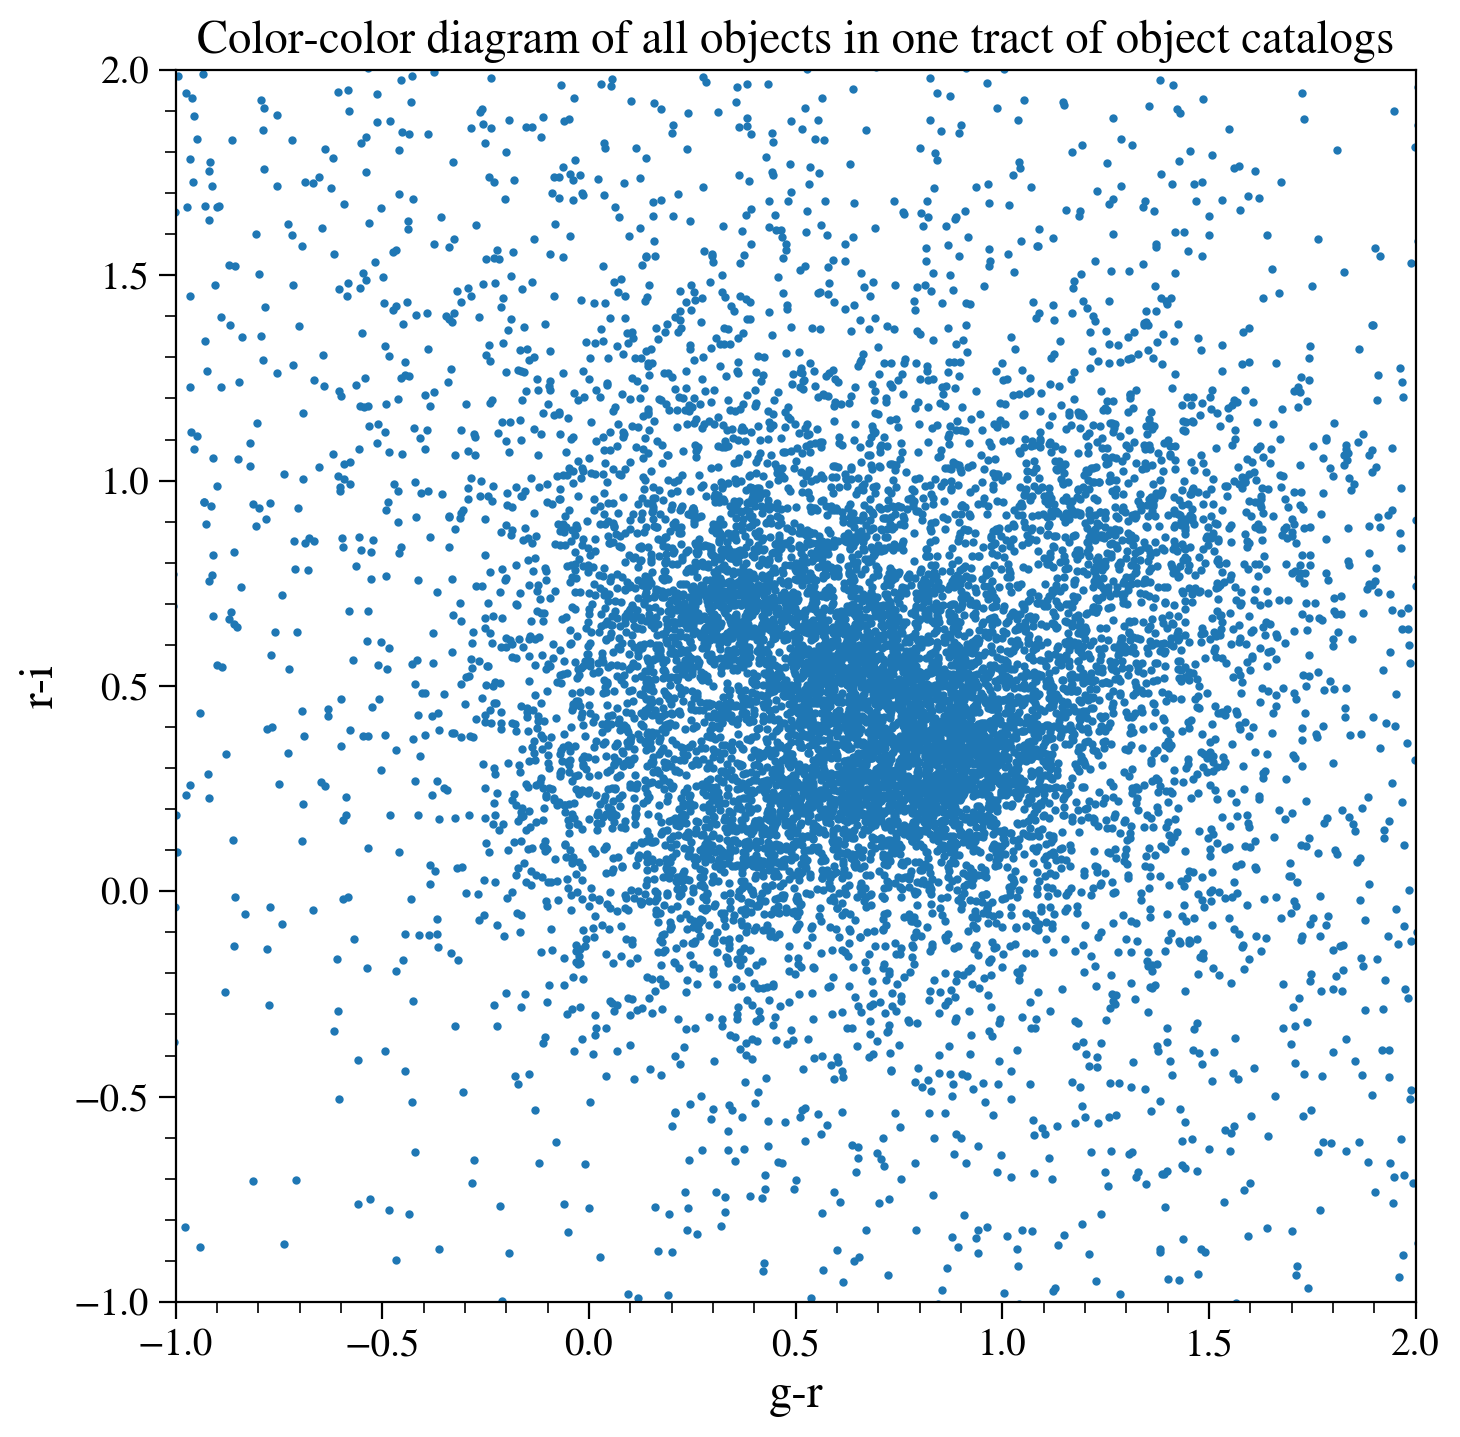

In [8]:
plt.figure(figsize=(8,8))
plt.scatter(df['g_mag'] - df['r_mag'], df['r_mag'] - df['i_mag'], marker='.')
plt.xlim(-1, +2)
plt.ylim(-1, +2)
plt.xlabel('g-r')
plt.ylabel('r-i')
plt.title('Color-color diagram of all objects in one tract of object catalogs')

This plot includes all objects, including lots of low SNR points and so is a bit of a mess, but maybe we're starting to see a bit of some structure resolving.  Let's do the traditional simple 2D histogram version:

Let's overplot a stellar locus from [Davenport et al., 2014, MNRAS, 440, 3430](http://adsabs.harvard.edu/abs/2014MNRAS.440.3430D)

In [9]:
def simple_stellar_locus_gmr_rmi(color='red', linestyle='--', linewidth=2.5):
    """Provide a simple two-slope definition of a stellar locus in (g-r, r-i).
    
    This simply defines one vertical line for M stars
    and the general slope for the bluer stars."""
    m_stars_gmr = [+1.4, +1.4]  # mag
    m_stars_rmi = [+0.5, +1.5]

    other_stars_gmr = [-0.5, +1.4]
    other_stars_rmi = [-0.4, +0.5]

    model_gmr = other_stars_gmr + m_stars_gmr
    model_rmi = other_stars_rmi + m_stars_rmi
    
    return model_gmr, model_rmi

    
def get_stellar_locus_davenport(color1='gmr', color2='rmi',
                                datafile='assets/Davenport_2014_MNRAS_440_3430_table1.txt'):
    data = pd.read_table(datafile, sep='\s+', header=1)
    return data[color1], data[color2]
    
    
def plot_stellar_locus(color1='gmr', color2='rmi',
                       color='red', linestyle='--', linewidth=2.5):
    model_gmr, model_rmi = get_stellar_locus_davenport(color1, color2)
    plot_kwargs = {'linestyle': linestyle, 'linewidth': linewidth, 'color': color,
                   'scalex': False, 'scaley': False}
    plt.plot(model_gmr, model_rmi, **plot_kwargs)

In [10]:
def plot_color_color(z, color1, color2, range1=(-1, +2), range2=(-1, +2), bins=31):
    """Plot a color-color diagram.  Overlay stellar locus"""
    band1, band2 = color1[0], color1[-1]
    band3, band4 = color2[0], color2[-1]
    H, xedges, yedges = np.histogram2d(
        z['%s_mag' % band1] - z['%s_mag' % band2],
        z['%s_mag' % band3] - z['%s_mag' % band4],
        range=(range1, range2), bins=bins)
        
    zi = H.T
    xi = (xedges[1:] + xedges[:-1])/2
    yi = (yedges[1:] + yedges[:-1])/2

    plt.figure(figsize=(8, 8))
    plt.pcolormesh(xi, yi, zi, cmap=cmap)
    plt.contour(xi, yi, zi)
    plt.xlabel('%s-%s' % (band1, band2))
    plt.ylabel('%s-%s' % (band3, band4))

    plot_stellar_locus(color1, color2)

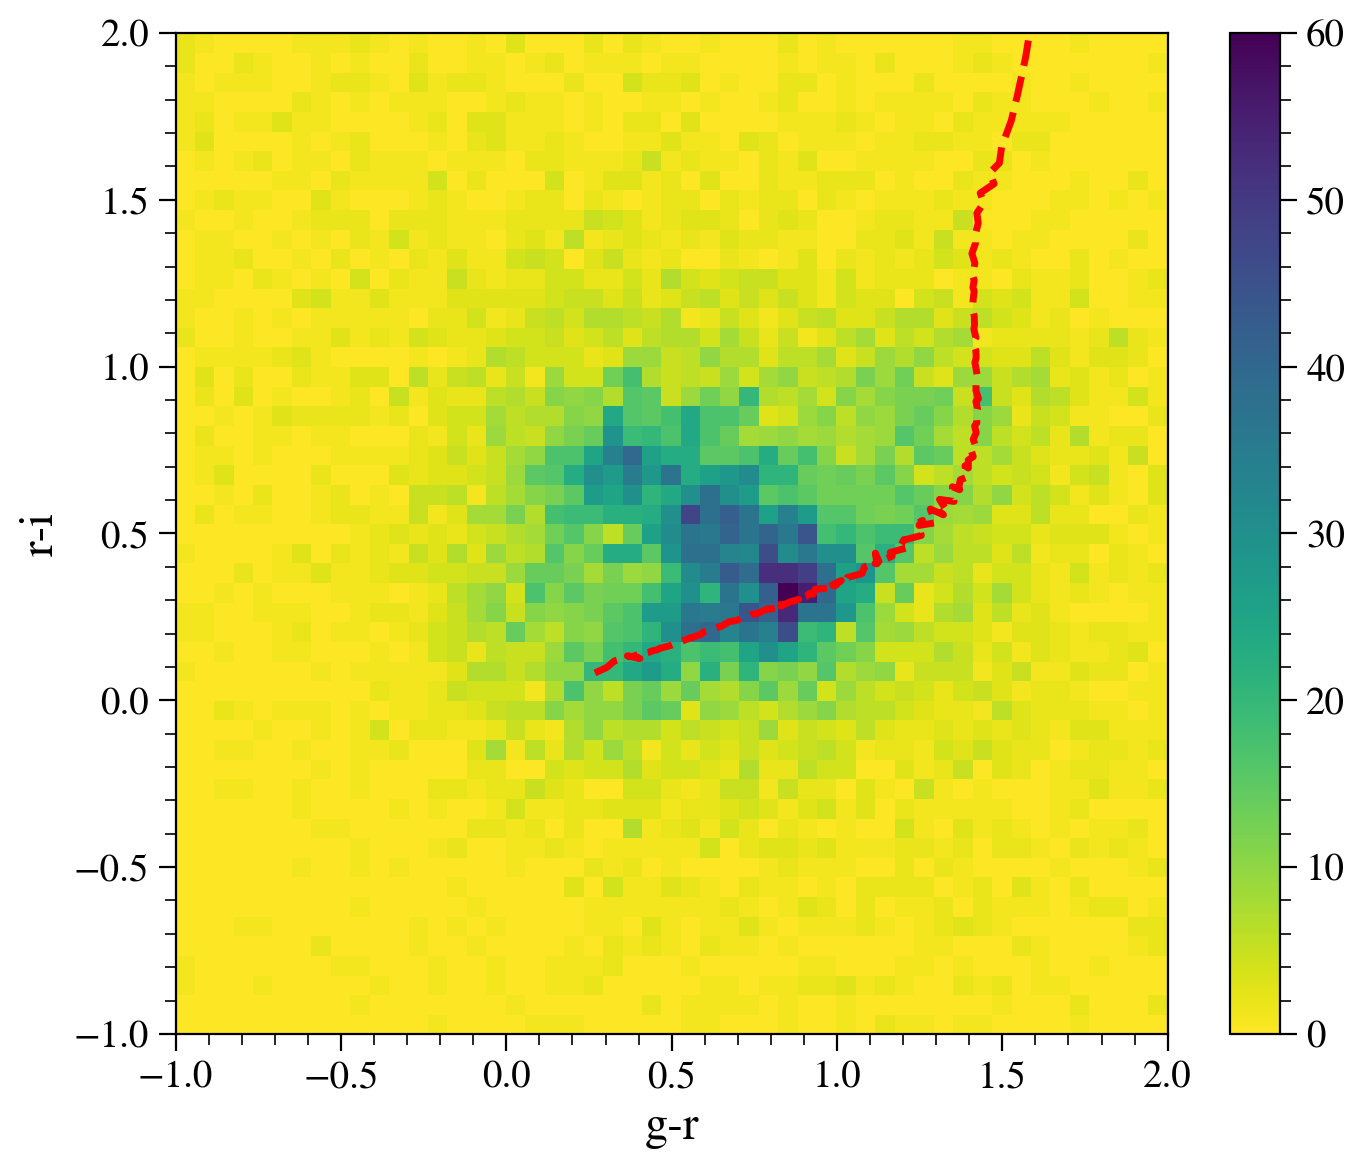

In [11]:
plt.figure(figsize=(8,6.5))
plt.hist2d(df['g_mag']-df['r_mag'], df['r_mag']-df['i_mag'],
           cmap=cmap, range=((-1, +2), (-1, +2)), bins=51)
plt.colorbar()
plt.xlabel('g-r')
plt.ylabel('r-i')

plot_stellar_locus('gmr', 'rmi')

(Don't worry about the runtime error.  There are some NaNs in the catalog magnitudes)

### Restrict to "good" sources
Clean this up a bit to define
 1. objects with SNR > 25 in g and r.
 2. stars from this SNR > 25 sample.
 3. bright-star set consistent with the usage in the LSST SRD of stars with SNR~100 (although that threshold may arguably be meant to be on the SNR in individual images).
 
The DM Science Pipeline calculates an 'extendness', which is the degree to which an object is classified as 'extended', i.e., not a point source (star).  To select stars, we select for objects with an extendeness classification less than 1.

In [12]:
snr_threshold = 25
mag_err_threshold = 1/snr_threshold
good_snr = df[(df['g_mag_err'] < mag_err_threshold) & (df['r_mag_err'] < mag_err_threshold)]

In [13]:
bright_snr_threshold = 100
mag_err_threshold = 1/bright_snr_threshold
bright_stars = df[(df['g_mag_err'] < mag_err_threshold) & (df['r_mag_err'] < mag_err_threshold)]

In [14]:
safe_max_extended = 1.0
stars = good_snr[good_snr['base_ClassificationExtendedness_value'] < safe_max_extended]
galaxies = good_snr[good_snr['base_ClassificationExtendedness_value'] >= safe_max_extended]

In [15]:
print("%d stars (SNR > %.0f)" % (len(stars), snr_threshold))
print("%d bright stars (SNR > %.0f)" % (len(bright_stars), bright_snr_threshold))

523 stars (SNR > 25)
509 bright stars (SNR > 100)


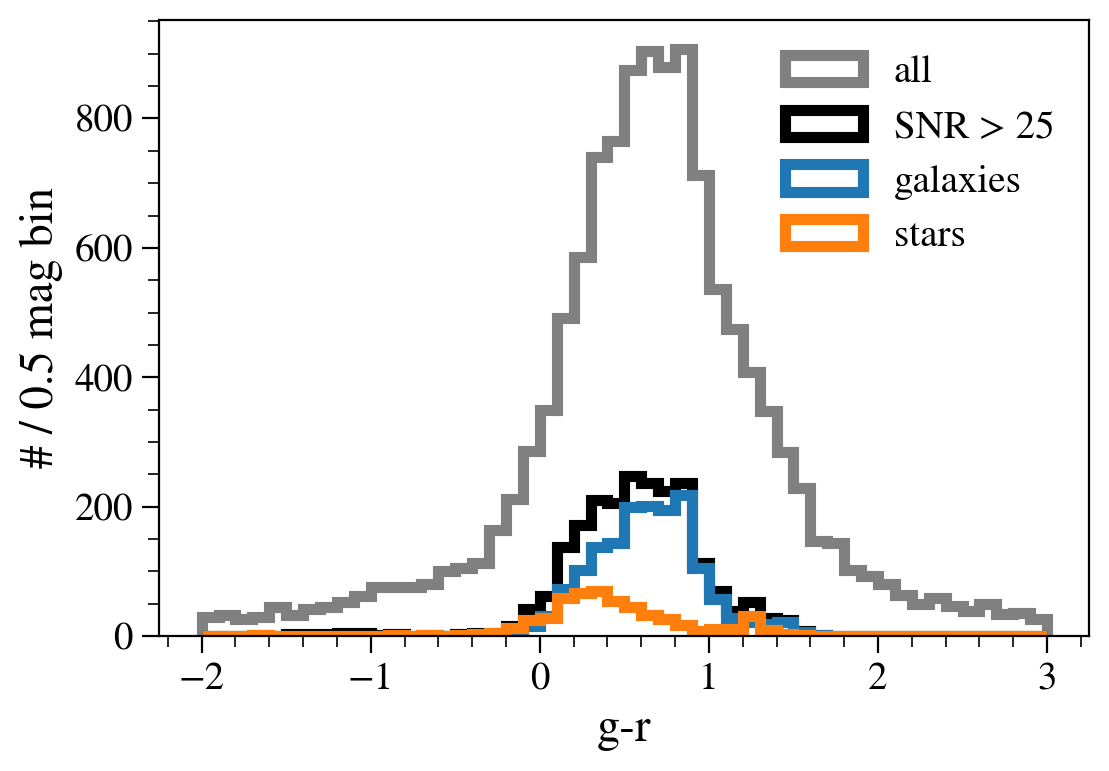

In [16]:
hist_kwargs = {'bins': np.linspace(-2, 3, 51),
               'range': (-2, +3),
               'linewidth': 4,
               'histtype': 'step'}
          
plt.hist(df['g_mag'] - df['r_mag'], label='all', color='grey', **hist_kwargs)
plt.hist(good_snr['g_mag'] - good_snr['r_mag'], label='SNR > %.0f' % snr_threshold, color='black',
         **hist_kwargs)
plt.hist(galaxies['g_mag'] - galaxies['r_mag'], label='galaxies', **hist_kwargs)
plt.hist(stars['g_mag'] - stars['r_mag'], label='stars', **hist_kwargs)
plt.xlabel('g-r')
plt.ylabel('# / 0.5 mag bin')
plt.legend()

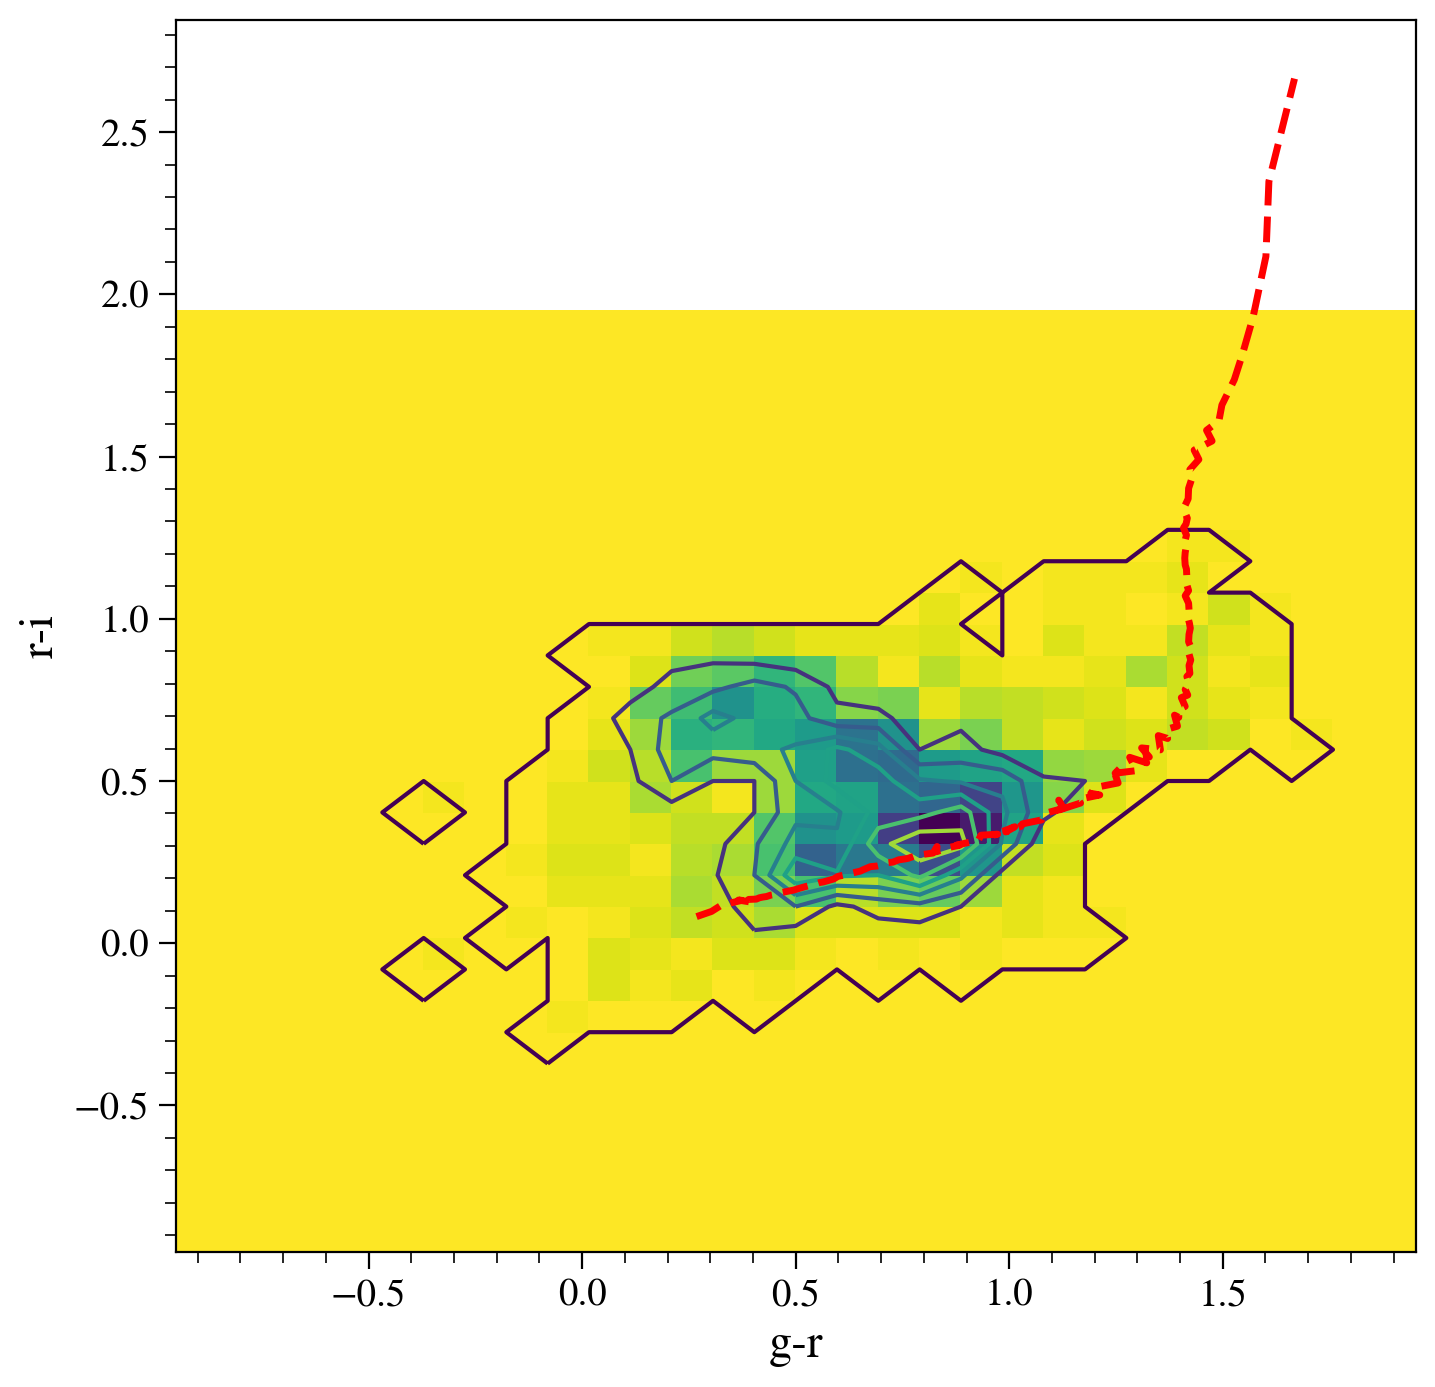

In [17]:
plot_color_color(galaxies, 'gmr', 'rmi')

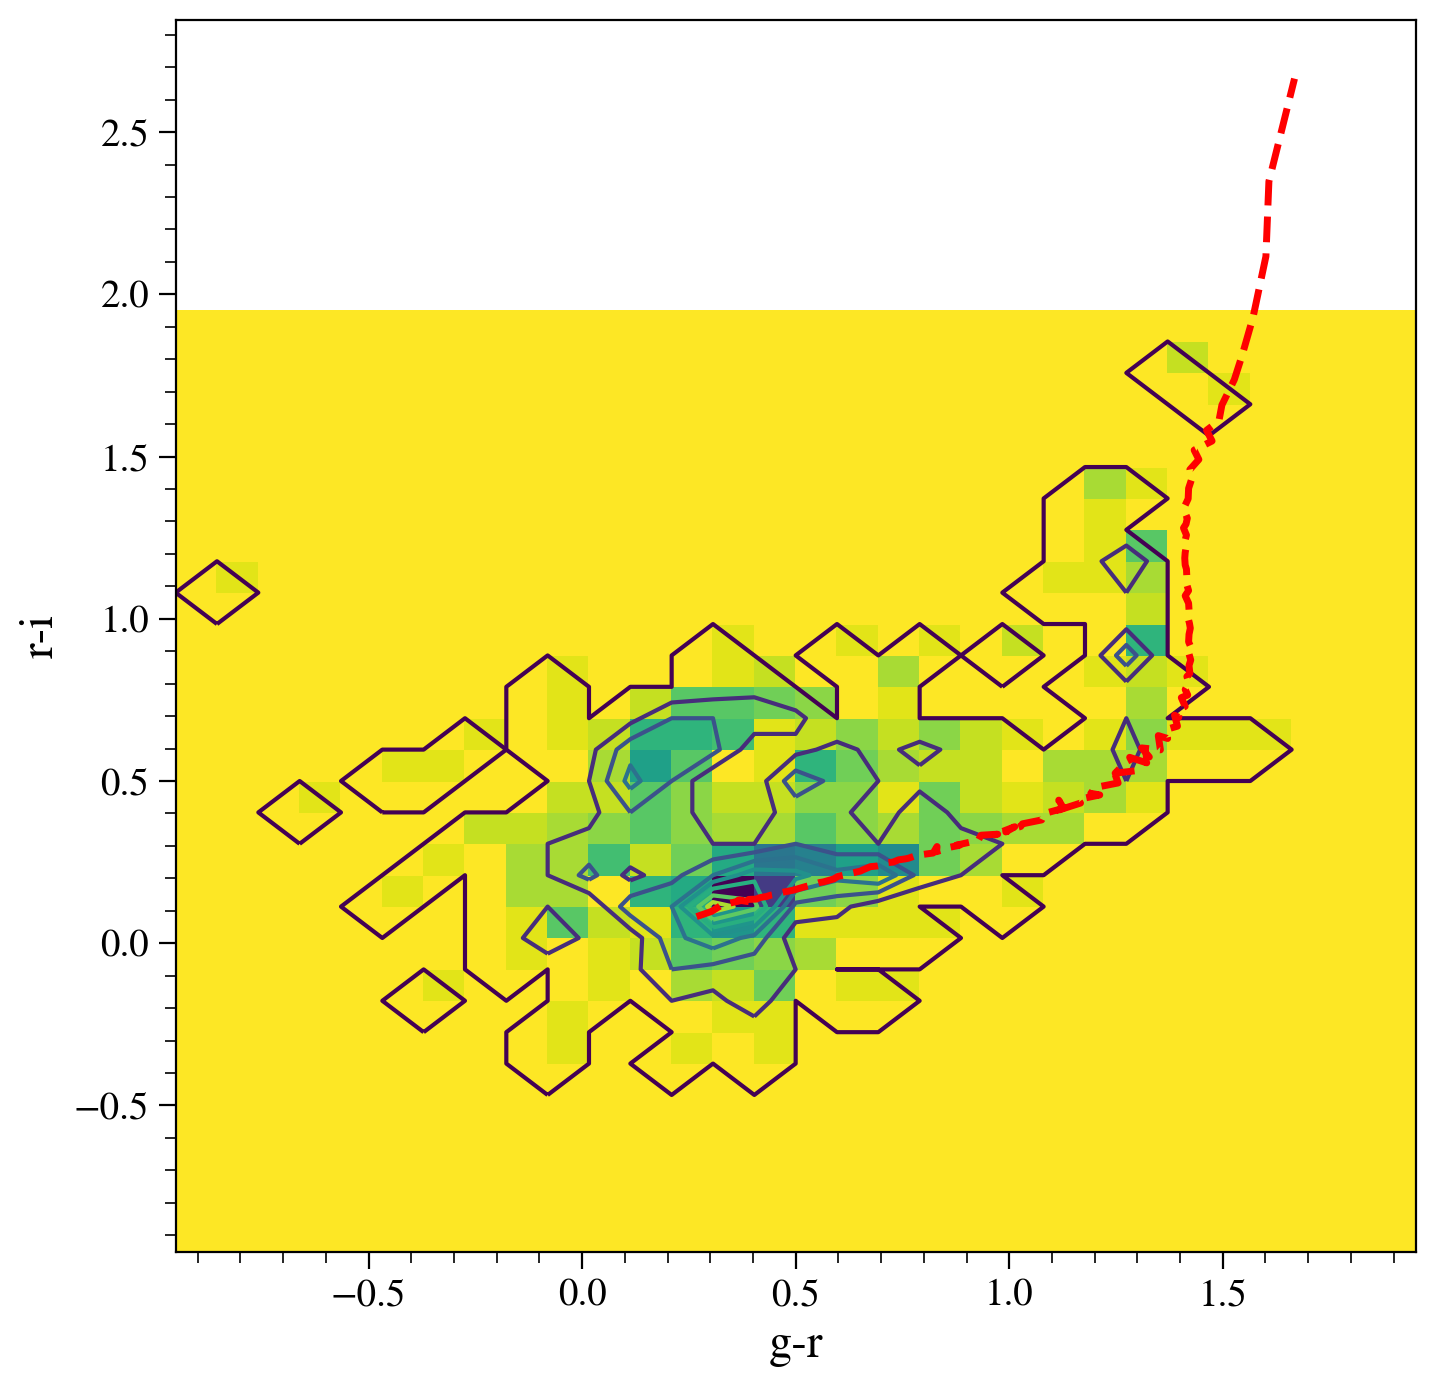

In [18]:
plot_color_color(stars, 'gmr', 'rmi')

1. You can see that we still have some galaxies, but otherwise we're starting to see the stars following the red line.
2. There's a slight offset with the red line, but we haven't really worried exactly about dust, metallicity, or filter transmission functions.

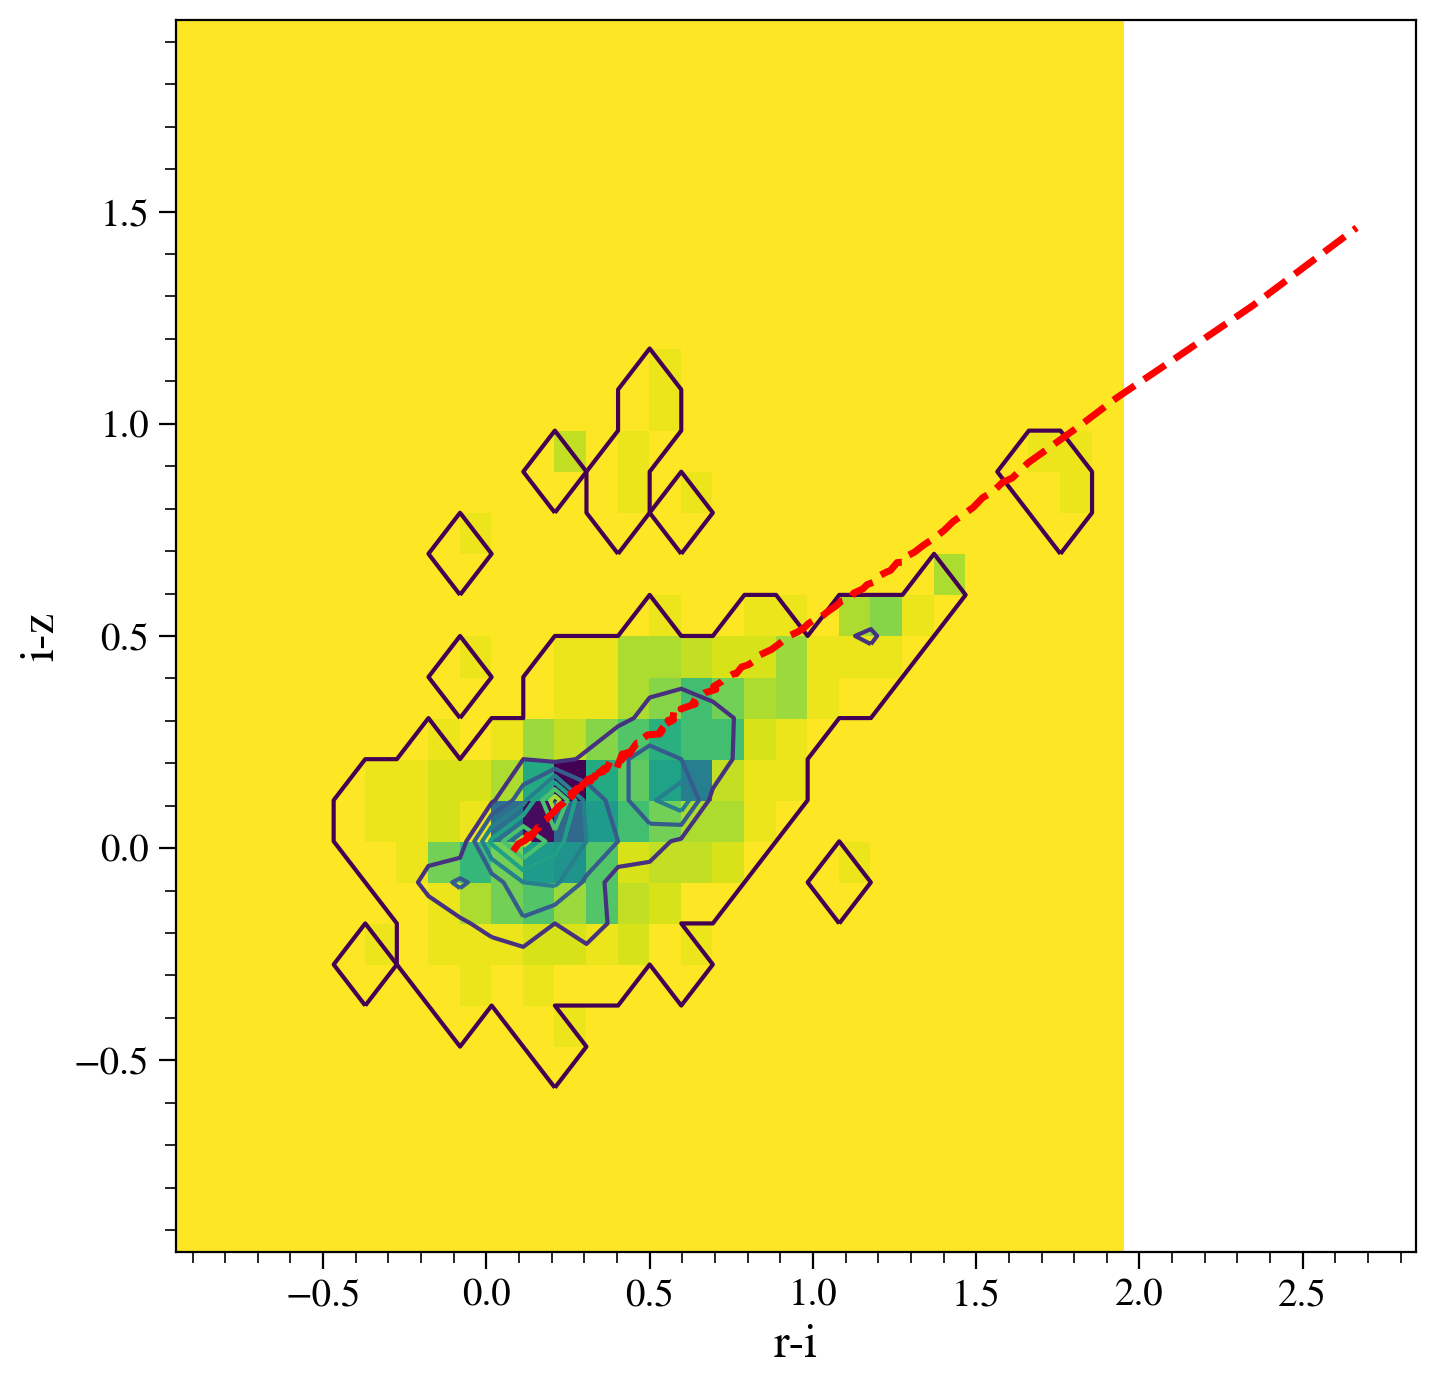

In [19]:
plot_color_color(stars, 'rmi', 'imz')

Let's briefly look at the (inverse) magnitude error vs. magnitude to see if the behavior seems reasonable.

(15.0, 28.0)

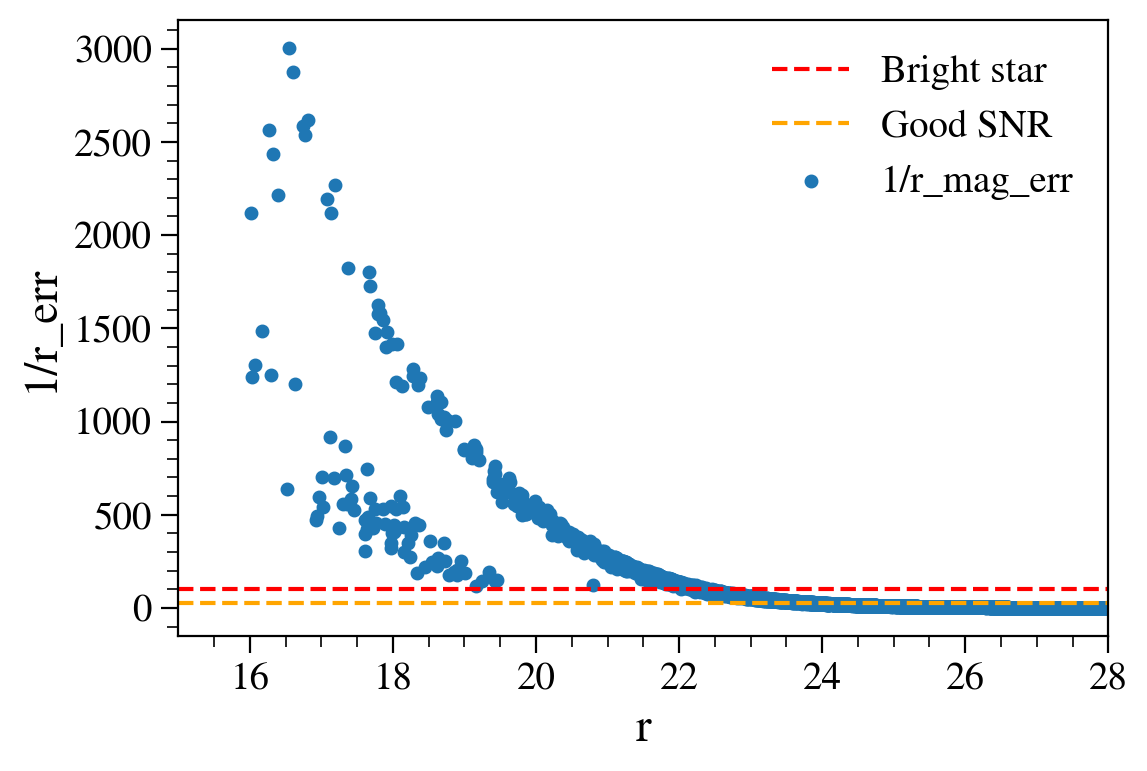

In [20]:
plt.scatter(df['r_mag'], 1/df['r_mag_err'], label='1/r_mag_err')
plt.xlabel('r')
plt.ylabel('1/r_err')
plt.axhline(bright_snr_threshold, linestyle='--', color='red', label='Bright star')
plt.axhline(snr_threshold, linestyle='--', color='orange', label='Good SNR')
plt.legend()
plt.xlim(15, 28)
# plt.ylim(0, 1.0)

I don't fully understand this above plot.

### Color-Magnitude plot

Stars and galaxies also occupy different, but overlapping spaces in color-magnitude plots.  Here are SDSS color-magnitude and color-color plots for g, r, i.  Above we looked at the lower, color-color plots.

http://www.astroml.org/examples/datasets/plot_sdss_imaging.html
![](http://www.astroml.org/_images/plot_sdss_imaging_1.png)

Let's see what we get from our simulations->images->DM science pipeline processing for the color-magnitude plots.

Text(0.5, 1.0, 'Galaxies')

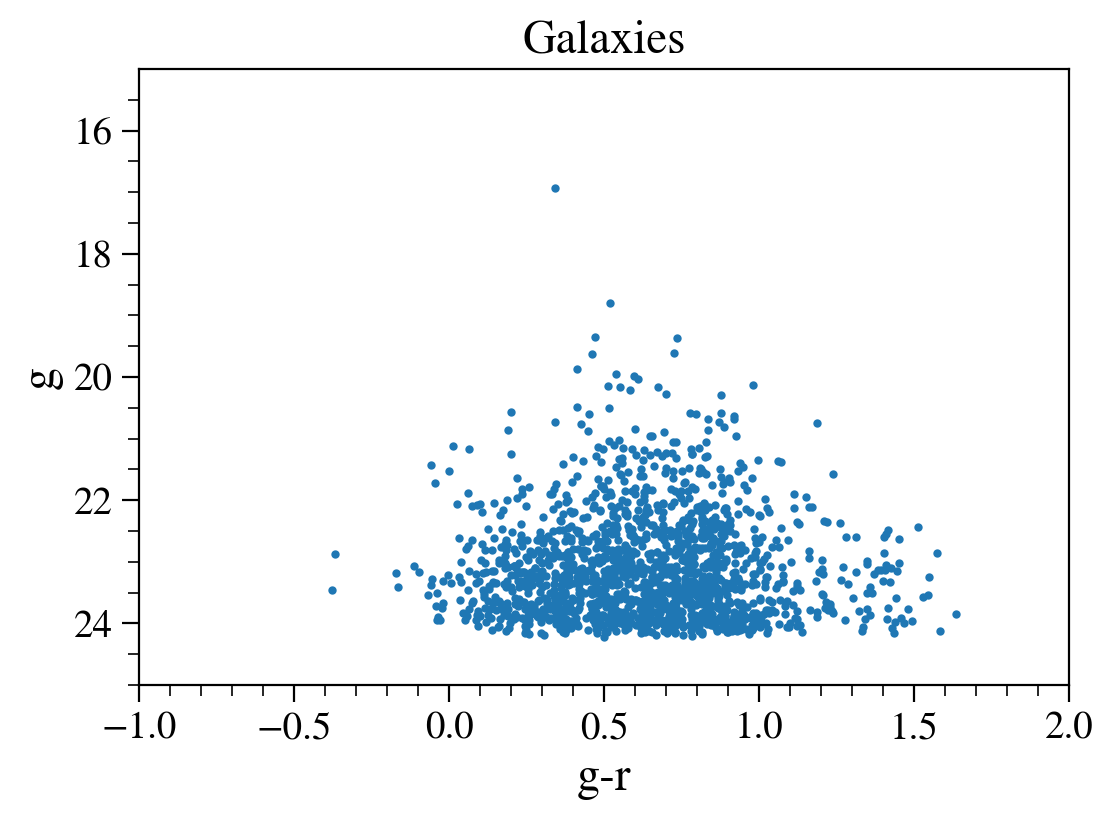

In [21]:
z = galaxies
plt.scatter(z['g_mag'] - z['r_mag'], z['g_mag'], marker='.', label='galaxies')
plt.xlabel('g-r')
plt.ylabel('g')
plt.xlim(-1, +2)
plt.ylim(25, 15)
plt.title('Galaxies')

Compare to the upper-left plot from the AtroML visualization of the SDSS data.

Text(0.5, 1.0, 'Stars')

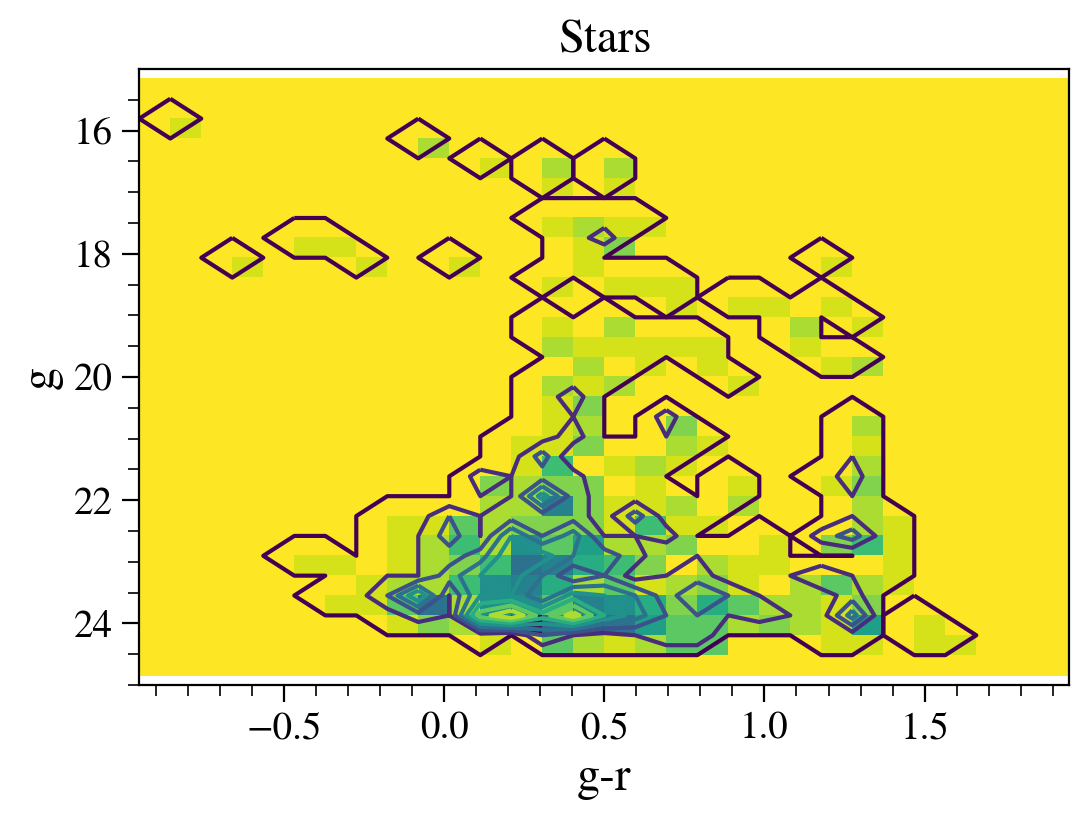

In [22]:
z = stars
H, xedges, yedges = np.histogram2d(z['g_mag']-z['r_mag'], z['g_mag'],
                                    range=((-1, +2), (15, 25)), bins=31)
zi = H.T
xi = (xedges[1:] + xedges[:-1])/2
yi = (yedges[1:] + yedges[:-1])/2

plt.pcolormesh(xi, yi, zi, cmap=cmap)
plt.contour(xi, yi, zi)
plt.xlabel('g-r')
plt.ylabel('g')
plt.ylim(25, 15)
plt.title('Stars')

Compare to the upper-right plot from the AtroML visualization of the SDSS data.  It looks reasonable, but we still have significant galaxy contamination, as we similarly saw in the color-color plots above.

## Appendix

## Generic Catalog Reader (GCR)

After a little bit you'll find yourself wanting to ask interesting questions, like how well does the DC2 analysis recover the input sources?  Or easily loading in all of the patches of a tract.  A convenient framework for generalizing analyses of DESC-DC related catalogs is the Generic Catalog Reader:

* GCR is a general utility
https://github.com/yymao/generic-catalog-reader
* The catalogs supporting DC2 are in:
https://github.com/LSSTDESC/gcr-catalogs

See the "DC2 object Run1.1p GCR tutorial" series!
For an example of using the GCR to do work similar to the agove:
[DC2 object Run1.1p GCR tutorial -- Part I: GCR Access.ipynb](object_gcr_1_intro.ipynb)